# Initialize Libraries

In [160]:
var = None

In [161]:
import numpy as np
import networkx as nx
import copy
import matplotlib.pyplot as plt
import pandas as pd

class adjmatrix:
    def __init__(self):
        # initialize a 1000x1000 matrix *mainly distance
        size = 10
        
        #edges
        self.matrix = np.zeros(shape=(size,size))
        self.edge_uv = np.array([[np.nan,np.nan,np.nan,np.nan]]) #np.empty(shape=[0, 4])
        
        #nodes
        self.nodedata = np.array([[0,0,0,0]]) # x,y,theta,z, includes features and poses (MEASURED)
        self.node = np.array([0]) # +1 for pose, -1 for landmarks, max is pose, min is landmarks
        
        self.converge = np.array([[]]) # store convergence
        
        self.cost = []
        
    # U is the pose to pose measurements
    def posetopose(self, uX, uY, uO, uZ):
        
        lastpose = max(self.node)
        ind, = np.where(self.node == lastpose)
        index_lastpose = ind[0]
        
        u = np.array([uX, uY, uO, uZ])
        
        #1 add a new node (pose) 
        node_type = max(self.node)+1  #pose index max + 1
        self.node = np.append(self.node, node_type)
        self.nodedata = np.append(self.nodedata, [self.nodedata[index_lastpose] + u], axis = 0) #measured node = U + previous node

        #2 add a new edge
        self.edge_uv = np.append(self.edge_uv, [u], axis = 0) #append u
        index_lastedge = len(self.edge_uv)-1
        self.matrix[index_lastpose][len(self.node)-1] = index_lastedge  #pose to newest node
        
    def poseloopclosure(self, uX, uY, uO, uZ, pose):
        lastpose = max(self.node)
        ind, = np.where(self.node == lastpose)
        index_lastpose = ind[0]
        
        u = np.array([uX, uY, uO, uZ])
        
        #1 add a new node (feature)
        #dont do anything

        #2 add a new edge
        self.edge_uv = np.append(self.edge_uv, [u], axis = 0) #append u
        index_lastedge = len(self.edge_uv)-1
        
        pose_index = np.where(self.node == pose)
        self.matrix[index_lastpose][pose_index] = index_lastedge  #pose to newest node
        
        
    def posetonewfeat(self, vX, vY, vO, vZ):
        
        lastpose = max(self.node)
        ind, = np.where(self.node == lastpose)
        index_lastpose = ind[0]
        
        v = np.array([vX, vY, vO, vZ])
        
        #1 add a new node (feature)
        node_type =  min(self.node)-1 #pose index max + 1
        self.node = np.append(self.node, node_type)
        self.nodedata = np.append(self.nodedata, [self.nodedata[index_lastpose] + v], axis = 0) #measured node = U + previous node
        
        
        #2 add a new edge
        self.edge_uv = np.append(self.edge_uv, [v], axis = 0) #append u
        index_newedge = len(self.edge_uv)-1
        self.matrix[index_lastpose][len(self.node)-1] = index_newedge  #pose to newest node
        
    def posetooldfeat(self,vX, vY, vO, vZ, feat):
        
        lastpose = max(self.node)
        ind, = np.where(self.node == lastpose)
        index_lastpose = ind[0]
        
        v = np.array([vX, vY, vO, vZ])
        
        #1 add a new node (feature)
        #dont do anything
        
        #2 add a new edge
        self.edge_uv = np.append(self.edge_uv, [v], axis = 0) #append u
        index_newedge = len(self.edge_uv)-1 #index of new edge
        
        feat_index = np.where(self.node == feat)
        
        self.matrix[index_lastpose][feat_index] = index_newedge  #pose to newest node

    
    def getcost(self, nodedata):
        x = np.where(self.matrix != 0)
        edges = np.asarray(x).T
        cost = 0
        for edge in edges:
            node_1 = nodedata[edge[1]] #node coordinates
            node_2 = nodedata[edge[0]] #node coordinates
            meas = self.edge_uv[int(self.matrix[edge[0]][edge[1]])]
            #print(node_1,node_2,meas)
            
            if self.node[edge[1]] > 0 and self.node[edge[0]] > 0 : #if pose to pose, dont count z
                #remove z values in error
                error = node_1 - node_2 - meas
                error = error - np.array([0,0,0,error[3]])
                errorsq = (error)**2
                #print("p2p")
                
            else: #if pose to feat, dont count o
                #remove o values
                error = node_1 - node_2 - meas
                error = error - np.array([0,0,error[2],error[3]])
                errorsq = (error)**2
                #print("p2f")
    
            cost = cost + np.linalg.norm(errorsq)
        #print ("cost",cost)
        return cost
        
    def getgradient(self,state):
        
        ind = []
        outd = []
        factor = []
        for i in range(len(self.node)):
            in_d = np.count_nonzero(self.matrix[:, i])
            out_d = np.count_nonzero(self.matrix[i, :])
            ind.append(in_d)
            outd.append(out_d)
            factor.append(-2*(out_d-in_d))
        print("in", ind)
        print("out", outd)
        print("factor", factor)
        print("\n")
        
        return factor
    
    
    def graph_posegraph(self,nodedata,i):
        
        if nodedata == []:
            nodedata = self.nodedata
        
        amat = self.matrix
        g = nx.from_numpy_matrix(amat, create_using=nx.DiGraph)
        g.remove_nodes_from(list(nx.isolates(g)))
        
        #relabelling
        mapping = dict(zip(g, self.node))
        g = nx.relabel_nodes(g, mapping)
        
        #colourmap
        color_map = []
        for node in g.nodes:
            if node < 0:
                color_map.append('red')
            else: 
                color_map.append('white')      
                
        #layout
        layout = nx.spectral_layout(g)
        #layout = nx.spring_layout(g)
        
        #position
        position = copy.deepcopy(nodedata)
        ps = []
        for pos in position:
            ps.append(pos[:2])
        
        z = zip(self.node, ps)
        dic = dict(z)
        
        fig, ax = plt.subplots()
        
        nx.draw_networkx(g, pos=dic, node_color= color_map, with_labels = True)
        nx.draw_networkx_labels(g, pos=dic)
        plt.axis("on")
        #ax.set_xlim(-1, 8)
        #ax.set_ylim(-1,8)
        ax.set_xlim(0.5, -1)
        ax.set_ylim(0.5, -1)
        
        ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
        
        plt.savefig("pose/{}.jpg".format(i))
        plt.show()
        #print (amat)
        
        
    def gd(self, iterations, learning_rate, stopping_threshold, posegraph):
        
        currentstate = self.nodedata
        print("original")
        print(currentstate)
        
        factor = np.array(self.getgradient(currentstate))
        
        
        #copy to new
        newstate = copy.deepcopy(currentstate)
        previouscost = self.getcost(newstate)

        #learn
        for i in range(iterations):#
            
            if previouscost == 0: #perfect calculations
                break
            
            #print nodes update
            if (i % 1 == 0):
                print(i)
                print(newstate)
                if posegraph == True:
                    self.graph_posegraph(newstate,i)
            
            #get gradient
            gradient = copy.deepcopy(newstate)
            for i in range(gradient.shape[0]): #by nodes.
                
                if self.node[i] > 0: #pose node; remove all z
                    gradient[i] = gradient[i] - np.array([0,0,gradient[i][2],gradient[i][3]])
                else: #feat node; remove all o
                    gradient[i] = gradient[i] - np.array([0,0,gradient[i][2],0])
                    
                gradient[i] = gradient[i]*factor[i]
            #print("gradient\n",gradient)
            
            newstate = newstate + learning_rate*gradient #ONLY UPDATE THE NECCESSARY VARIABLES.
            currentcost = self.getcost(newstate)
            print ("curcost",currentcost)
            print()
            self.cost.append(currentcost)
            #print ("prvcost",previouscost)
            
            if currentcost > previouscost:
                break
            
            previouscost = currentcost 
        
        print("converge")
        print(newstate)
        self.converge = newstate
    
        
    def graph_location(self, nodedata):
        pose_ind, = np.where(self.node >= 0)
        land_ind, = np.where(self.node < 0)
        print (pose_ind,land_ind)
        #colour identity
    
    def pr(self):
        print ("node (pose/landmark)\n",self.node)
        print ("nodedata (assumed state)\n",self.nodedata)
        print ("edgedata (u/v)\n",self.edge_uv)
        print ("\n")
        print (np.matrix(self.matrix))
        print ()
    
    def prcost(self):
        ite = list(range(0, len(self.cost)))
        cs = self.cost
        plt.plot(ite,cs)
        plt.title('Cost vs Iterations')
        plt.xlabel('Iterations')
        plt.ylabel('Costs')
        plt.show()
        #print (self.cost)
         

# Intializing Matrix, 
Measured Data (from excel)
Compare with Ground Truth

In [162]:
#df = pd.read_csv("dataset/e3v2.csv")
#df = pd.read_csv("dataset/e3v4xyswap.csv")
df = pd.read_csv("dataset/e3v4initialcoordsswap.csv")
#df = df[0:10]
df

,Type,Match,Node,x,y,o,z
0,Pose,NaN,1,0.000246,-0.000019,-0.000348,-99999.000000
1,Feat,NaN,-1,-0.015858,-0.409518,-99999.000000,0.127412
2,Feat,NaN,-2,-0.166643,-0.380012,-99999.000000,0.136918
3,Pose,NaN,2,-0.291175,-0.007319,0.225321,-99999.000000
4,Feat,-1.0,-1,-0.039523,-0.507076,-99999.000000,0.169411
5,Feat,NaN,-3,-0.040635,-0.509414,-99999.000000,0.171712
6,Pose,NaN,3,-0.309739,-0.004296,0.099392,-99999.000000
7,Feat,-2.0,-2,-0.159924,-0.368080,-99999.000000,-0.143533
8,Feat,NaN,-4,-0.158795,-0.367972,-99999.000000,-0.142006
9,Feat,-1.0,-1,-0.039531,-0.495899,-99999.000000,0.174748


In [163]:
a = adjmatrix() 
for i in range(len(df)):
    e  = df.iloc[i]
    if e.Type == 'Pose':
        a.posetopose(e.x,e.y,e.o,e.z) #new pose x,y,o,{z}
    else:
        if pd.isna(e.Match):
            #add new feat
            a.posetonewfeat(e.x,e.y,e.o,e.z)
        else:
            #old feat, link
            a.posetooldfeat(e.x,e.y,e.o,e.z,e.Match)

# Visualize Gradient Descent

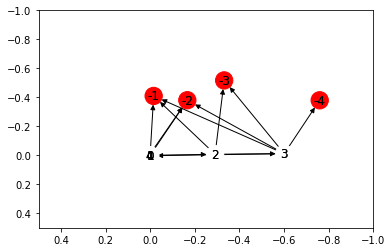

In [164]:
a.graph_posegraph([],0)

In [165]:
#a.nodedata[np.where(a.node>0)

# Visualize Gradient Descent

In [166]:
import os
import glob

#Clear 
files = glob.glob('pose/*')
for f in files:
    os.remove(f)

original
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.45727000e-04 -1.94000000e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.56119610e-02 -4.09537773e-01 -9.99990003e+04 -9.99988726e+04]
 [-1.66397321e-01 -3.80030907e-01 -9.99990003e+04 -9.99988631e+04]
 [-2.90929730e-01 -7.33817100e-03  2.24972808e-01 -1.99998000e+05]
 [-3.31564823e-01 -5.16752443e-01 -9.99987750e+04 -1.99997828e+05]
 [-6.00668669e-01 -1.16344390e-02  3.24364498e-01 -2.99997000e+05]
 [-7.59463857e-01 -3.79606694e-01 -9.99986756e+04 -2.99997142e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]
in [0, 1, 3, 3, 1, 2, 1, 1, 1]
out [1, 3, 0, 0, 3, 0, 5, 0, 1]
factor [-2, -4, 6, 6, -4, 4, -8, 2, 0]


0
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.45727000e-04 -1.94000000e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.56119610e-02 -4.09537773e-01 -9.99990003e+04 -9.99988726e+04]
 [-1.66397321e-01 -3.80030907e-01 -9.99990003e+04 -9.99988631e+04]
 [-2.90929730

<ipython-input-161-ab83cac5a11d>:149: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if nodedata == []:


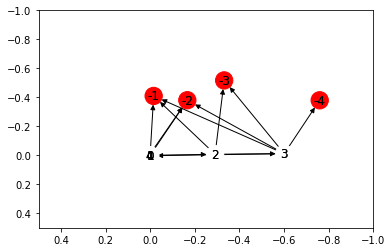

curcost 0.9253634353914721

1
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.44744092e-04 -1.93224000e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.57056328e-02 -4.11995000e-01 -9.99990003e+04 -1.00598866e+05]
 [-1.67395705e-01 -3.82311092e-01 -9.99990003e+04 -1.00598856e+05]
 [-2.89766011e-01 -7.30881832e-03  2.24972808e-01 -1.99998000e+05]
 [-3.32891082e-01 -5.18819453e-01 -9.99987750e+04 -2.00797820e+05]
 [-5.95863320e-01 -1.15413635e-02  3.24364498e-01 -2.99997000e+05]
 [-7.60982785e-01 -3.80365907e-01 -9.99986756e+04 -3.00597136e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


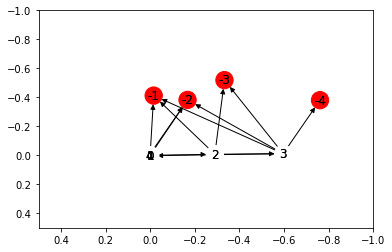

curcost 0.9086696726795556

2
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.43765116e-04 -1.92451104e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.57998666e-02 -4.14466970e-01 -9.99990003e+04 -1.01202459e+05]
 [-1.68400079e-01 -3.84604959e-01 -9.99990003e+04 -1.01202449e+05]
 [-2.88606947e-01 -7.27958304e-03  2.24972808e-01 -1.99998000e+05]
 [-3.34222647e-01 -5.20894731e-01 -9.99987750e+04 -2.01601011e+05]
 [-5.91096413e-01 -1.14490326e-02  3.24364498e-01 -2.99997000e+05]
 [-7.62504750e-01 -3.81126639e-01 -9.99986756e+04 -3.01198331e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


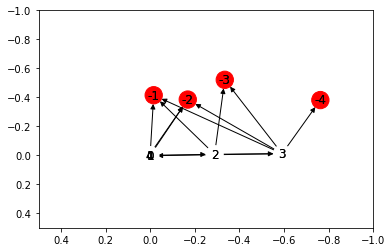

curcost 0.8924762538786495

3
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.42790055e-04 -1.91681300e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.58946658e-02 -4.16953771e-01 -9.99990003e+04 -1.01809674e+05]
 [-1.69410480e-01 -3.86912589e-01 -9.99990003e+04 -1.01809664e+05]
 [-2.87452519e-01 -7.25046471e-03  2.24972808e-01 -1.99998000e+05]
 [-3.35559537e-01 -5.22978310e-01 -9.99987750e+04 -2.02407415e+05]
 [-5.86367642e-01 -1.13574403e-02  3.24364498e-01 -2.99997000e+05]
 [-7.64029760e-01 -3.81888892e-01 -9.99986756e+04 -3.01800727e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


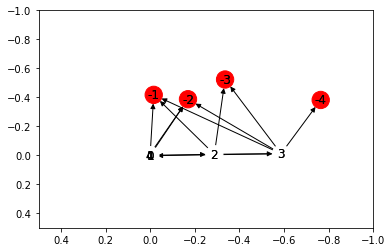

curcost 0.8767764574516363

4
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.41818895e-04 -1.90914574e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.59900338e-02 -4.19455494e-01 -9.99990003e+04 -1.02420532e+05]
 [-1.70426943e-01 -3.89234064e-01 -9.99990003e+04 -1.02420522e+05]
 [-2.86302709e-01 -7.22146285e-03  2.24972808e-01 -1.99998000e+05]
 [-3.36901775e-01 -5.25070223e-01 -9.99987750e+04 -2.03217045e+05]
 [-5.81676701e-01 -1.12665808e-02  3.24364498e-01 -2.99997000e+05]
 [-7.65557819e-01 -3.82652670e-01 -9.99986756e+04 -3.02404329e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


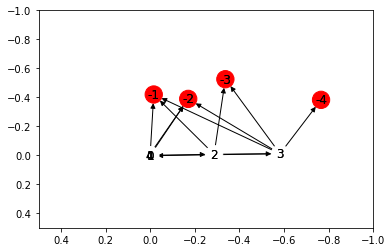

curcost 0.861563691720758

5
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.40851619e-04 -1.90150916e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.60859740e-02 -4.21972227e-01 -9.99990003e+04 -1.03035055e+05]
 [-1.71449504e-01 -3.91569469e-01 -9.99990003e+04 -1.03035045e+05]
 [-2.85157498e-01 -7.19257700e-03  2.24972808e-01 -1.99998000e+05]
 [-3.38249382e-01 -5.27170504e-01 -9.99987750e+04 -2.04029913e+05]
 [-5.77023287e-01 -1.11764482e-02  3.24364498e-01 -2.99997000e+05]
 [-7.67088935e-01 -3.83417976e-01 -9.99986756e+04 -3.03009137e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


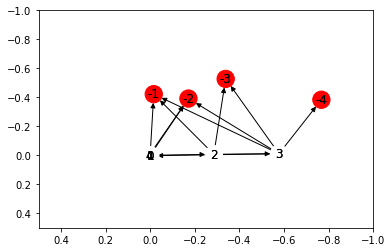

curcost 0.8468314964822193

6
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.39888213e-04 -1.89390312e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.61824898e-02 -4.24504060e-01 -9.99990003e+04 -1.03653265e+05]
 [-1.72478201e-01 -3.93918885e-01 -9.99990003e+04 -1.03653255e+05]
 [-2.84016868e-01 -7.16380669e-03  2.24972808e-01 -1.99998000e+05]
 [-3.39602380e-01 -5.29279186e-01 -9.99987750e+04 -2.04846032e+05]
 [-5.72407101e-01 -1.10870366e-02  3.24364498e-01 -2.99997000e+05]
 [-7.68623113e-01 -3.84184812e-01 -9.99986756e+04 -3.03615156e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


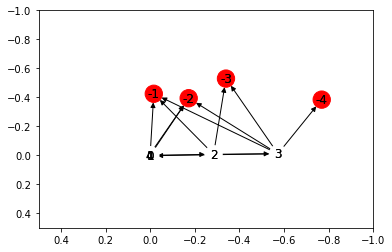

curcost 0.8325735449965307

7
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.38928660e-04 -1.88632751e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.62795847e-02 -4.27051085e-01 -9.99990003e+04 -1.04275185e+05]
 [-1.73513070e-01 -3.96282399e-01 -9.99990003e+04 -1.04275175e+05]
 [-2.82880801e-01 -7.13515147e-03  2.24972808e-01 -1.99998000e+05]
 [-3.40960790e-01 -5.31396302e-01 -9.99987750e+04 -2.05665417e+05]
 [-5.67827844e-01 -1.09983403e-02  3.24364498e-01 -2.99997000e+05]
 [-7.70160359e-01 -3.84953181e-01 -9.99986756e+04 -3.04222386e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


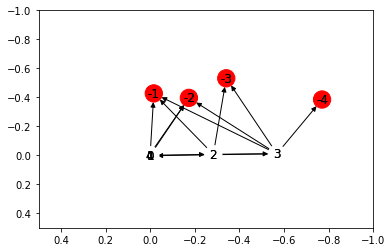

curcost 0.8187836463962554

8
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.37972945e-04 -1.87878220e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.63772623e-02 -4.29613391e-01 -9.99990003e+04 -1.04900836e+05]
 [-1.74554149e-01 -3.98660093e-01 -9.99990003e+04 -1.04900826e+05]
 [-2.81749278e-01 -7.10661086e-03  2.24972808e-01 -1.99998000e+05]
 [-3.42324633e-01 -5.33521888e-01 -9.99987750e+04 -2.06488078e+05]
 [-5.63285221e-01 -1.09103536e-02  3.24364498e-01 -2.99997000e+05]
 [-7.71700680e-01 -3.85723088e-01 -9.99986756e+04 -3.04830831e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


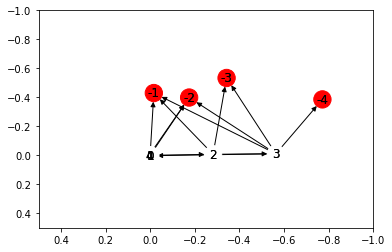

curcost 0.8054557485745936

9
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.37021054e-04 -1.87126707e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.64755258e-02 -4.32191072e-01 -9.99990003e+04 -1.05530241e+05]
 [-1.75601474e-01 -4.01052054e-01 -9.99990003e+04 -1.05530231e+05]
 [-2.80622281e-01 -7.07818442e-03  2.24972808e-01 -1.99998000e+05]
 [-3.43693931e-01 -5.35655975e-01 -9.99987750e+04 -2.07314031e+05]
 [-5.58778939e-01 -1.08230707e-02  3.24364498e-01 -2.99997000e+05]
 [-7.73244081e-01 -3.86494534e-01 -9.99986756e+04 -3.05440492e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


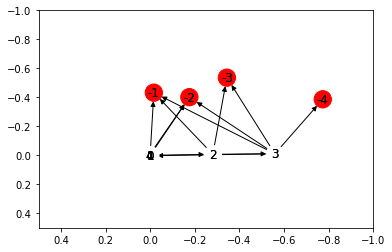

curcost 0.7925839416416446

10
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.36072969e-04 -1.86378200e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.65743790e-02 -4.34784218e-01 -9.99990003e+04 -1.06163422e+05]
 [-1.76655083e-01 -4.03458366e-01 -9.99990003e+04 -1.06163412e+05]
 [-2.79499791e-01 -7.04987168e-03  2.24972808e-01 -1.99998000e+05]
 [-3.45068707e-01 -5.37798599e-01 -9.99987750e+04 -2.08143287e+05]
 [-5.54308708e-01 -1.07364862e-02  3.24364498e-01 -2.99997000e+05]
 [-7.74790569e-01 -3.87267523e-01 -9.99986756e+04 -3.06051373e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


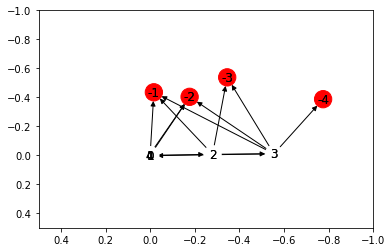

curcost 0.7801624620608846

11
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.35128678e-04 -1.85632688e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.66738253e-02 -4.37392923e-01 -9.99990003e+04 -1.06800403e+05]
 [-1.77715013e-01 -4.05879116e-01 -9.99990003e+04 -1.06800393e+05]
 [-2.78381792e-01 -7.02167219e-03  2.24972808e-01 -1.99998000e+05]
 [-3.46448982e-01 -5.39949793e-01 -9.99987750e+04 -2.08975860e+05]
 [-5.49874238e-01 -1.06505943e-02  3.24364498e-01 -2.99997000e+05]
 [-7.76340150e-01 -3.88042058e-01 -9.99986756e+04 -3.06663476e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


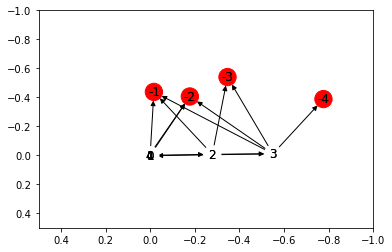

curcost 0.7681856976071397

12
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.34188163e-04 -1.84890157e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.67738682e-02 -4.40017281e-01 -9.99990003e+04 -1.07441205e+05]
 [-1.78781303e-01 -4.08314391e-01 -9.99990003e+04 -1.07441195e+05]
 [-2.77268265e-01 -6.99358550e-03  2.24972808e-01 -1.99998000e+05]
 [-3.47834778e-01 -5.42109593e-01 -9.99987750e+04 -2.09811763e+05]
 [-5.45475244e-01 -1.05653895e-02  3.24364498e-01 -2.99997000e+05]
 [-7.77892831e-01 -3.88818142e-01 -9.99986756e+04 -3.07276803e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


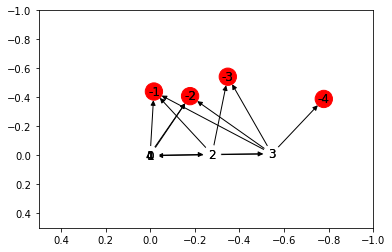

curcost 0.7566481933201841

13
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.33251410e-04 -1.84150596e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.68745114e-02 -4.42657385e-01 -9.99990003e+04 -1.08085853e+05]
 [-1.79853991e-01 -4.10764277e-01 -9.99990003e+04 -1.08085842e+05]
 [-2.76159192e-01 -6.96561116e-03  2.24972808e-01 -1.99998000e+05]
 [-3.49226117e-01 -5.44278031e-01 -9.99987750e+04 -2.10651010e+05]
 [-5.41111442e-01 -1.04808664e-02  3.24364498e-01 -2.99997000e+05]
 [-7.79448616e-01 -3.89595778e-01 -9.99986756e+04 -3.07891357e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


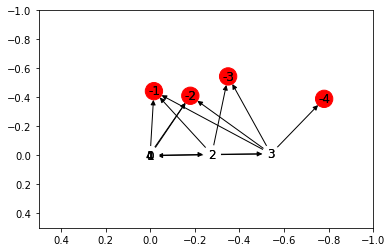

curcost 0.7455446586661425

14
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.32318405e-04 -1.83413994e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.69757585e-02 -4.45313329e-01 -9.99990003e+04 -1.08734368e+05]
 [-1.80933115e-01 -4.13228863e-01 -9.99990003e+04 -1.08734357e+05]
 [-2.75054555e-01 -6.93774872e-03  2.24972808e-01 -1.99998000e+05]
 [-3.50623021e-01 -5.46455143e-01 -9.99987750e+04 -2.11493614e+05]
 [-5.36782551e-01 -1.03970195e-02  3.24364498e-01 -2.99997000e+05]
 [-7.81007514e-01 -3.90374970e-01 -9.99986756e+04 -3.08507139e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


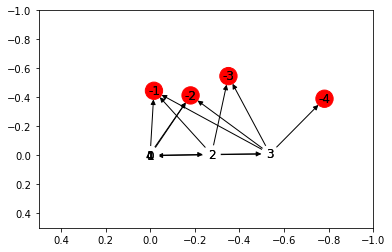

curcost 0.7348699761634027

15
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.31389131e-04 -1.82680338e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.70776130e-02 -4.47985209e-01 -9.99990003e+04 -1.09386774e+05]
 [-1.82018714e-01 -4.15708236e-01 -9.99990003e+04 -1.09386764e+05]
 [-2.73954337e-01 -6.90999772e-03  2.24972808e-01 -1.99998000e+05]
 [-3.52025513e-01 -5.48640964e-01 -9.99987750e+04 -2.12339589e+05]
 [-5.32488290e-01 -1.03138433e-02  3.24364498e-01 -2.99997000e+05]
 [-7.82569529e-01 -3.91155720e-01 -9.99986756e+04 -3.09124154e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


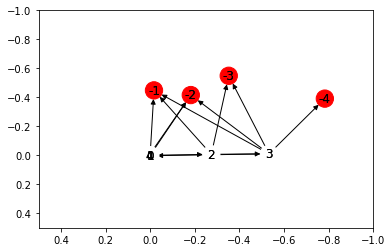

curcost 0.724619211781993

16
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.30463574e-04 -1.81949617e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.71800787e-02 -4.50673120e-01 -9.99990003e+04 -1.10043095e+05]
 [-1.83110826e-01 -4.18202486e-01 -9.99990003e+04 -1.10043084e+05]
 [-2.72858520e-01 -6.88235773e-03  2.24972808e-01 -1.99998000e+05]
 [-3.53433615e-01 -5.50835528e-01 -9.99987750e+04 -2.13188947e+05]
 [-5.28228384e-01 -1.02313326e-02  3.24364498e-01 -2.99997000e+05]
 [-7.84134668e-01 -3.91938031e-01 -9.99986756e+04 -3.09742402e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


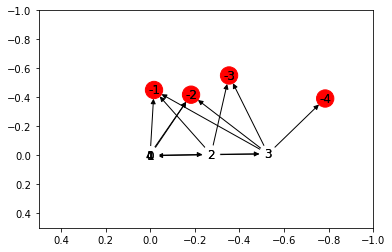

curcost 0.7147876274864172

17
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.29541720e-04 -1.81221818e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.72831592e-02 -4.53377159e-01 -9.99990003e+04 -1.10703353e+05]
 [-1.84209491e-01 -4.20711700e-01 -9.99990003e+04 -1.10703343e+05]
 [-2.71767086e-01 -6.85482830e-03  2.24972808e-01 -1.99998000e+05]
 [-3.54847350e-01 -5.53038870e-01 -9.99987750e+04 -2.14041703e+05]
 [-5.24002557e-01 -1.01494819e-02  3.24364498e-01 -2.99997000e+05]
 [-7.85702937e-01 -3.92721907e-01 -9.99986756e+04 -3.10361887e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


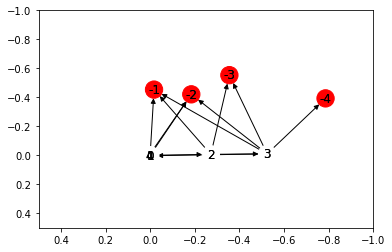

curcost 0.7053706963623653

18
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.28623553e-04 -1.80496931e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.73868581e-02 -4.56097422e-01 -9.99990003e+04 -1.11367573e+05]
 [-1.85314748e-01 -4.23235971e-01 -9.99990003e+04 -1.11367563e+05]
 [-2.70680017e-01 -6.82740899e-03  2.24972808e-01 -1.99998000e+05]
 [-3.56266739e-01 -5.55251025e-01 -9.99987750e+04 -2.14897870e+05]
 [-5.19810537e-01 -1.00682860e-02  3.24364498e-01 -2.99997000e+05]
 [-7.87274343e-01 -3.93507351e-01 -9.99986756e+04 -3.10982611e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


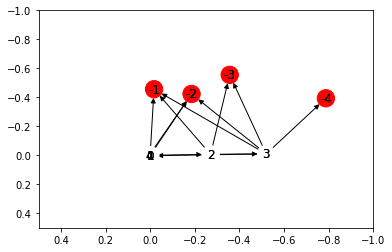

curcost 0.6963641208470326

19
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.27709059e-04 -1.79774943e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.74911793e-02 -4.58834006e-01 -9.99990003e+04 -1.12035779e+05]
 [-1.86426636e-01 -4.25775387e-01 -9.99990003e+04 -1.12035768e+05]
 [-2.69597297e-01 -6.80009935e-03  2.24972808e-01 -1.99998000e+05]
 [-3.57691806e-01 -5.57472029e-01 -9.99987750e+04 -2.15757461e+05]
 [-5.15652052e-01 -9.98773976e-03  3.24364498e-01 -2.99997000e+05]
 [-7.88848892e-01 -3.94294366e-01 -9.99986756e+04 -3.11604576e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


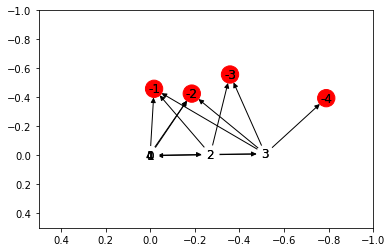

curcost 0.6877638546684768

20
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.26798223e-04 -1.79055843e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.75961264e-02 -4.61587010e-01 -9.99990003e+04 -1.12707993e+05]
 [-1.87545196e-01 -4.28330039e-01 -9.99990003e+04 -1.12707983e+05]
 [-2.68518908e-01 -6.77289895e-03  2.24972808e-01 -1.99998000e+05]
 [-3.59122573e-01 -5.59701917e-01 -9.99987750e+04 -2.16620491e+05]
 [-5.11526836e-01 -9.90783784e-03  3.24364498e-01 -2.99997000e+05]
 [-7.90426589e-01 -3.95082954e-01 -9.99986756e+04 -3.12227785e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


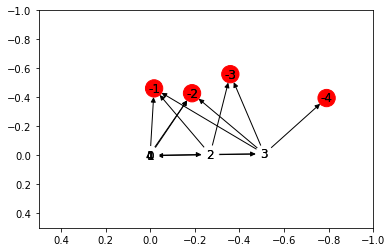

curcost 0.6795661291851631

21
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.25891030e-04 -1.78339620e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.77017031e-02 -4.64356532e-01 -9.99990003e+04 -1.13384241e+05]
 [-1.88670467e-01 -4.30900019e-01 -9.99990003e+04 -1.13384231e+05]
 [-2.67444832e-01 -6.74580736e-03  2.24972808e-01 -1.99998000e+05]
 [-3.60559064e-01 -5.61940725e-01 -9.99987750e+04 -2.17486973e+05]
 [-5.07434621e-01 -9.82857514e-03  3.24364498e-01 -2.99997000e+05]
 [-7.92007443e-01 -3.95873120e-01 -9.99986756e+04 -3.12852240e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


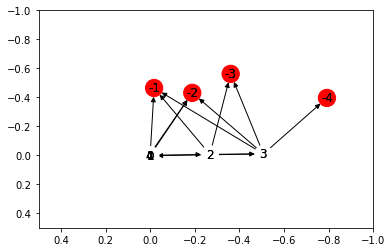

curcost 0.6717674848898618

22
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.24987466e-04 -1.77626261e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.78079133e-02 -4.67142672e-01 -9.99990003e+04 -1.14064547e+05]
 [-1.89802490e-01 -4.33485419e-01 -9.99990003e+04 -1.14064536e+05]
 [-2.66375053e-01 -6.71882413e-03  2.24972808e-01 -1.99998000e+05]
 [-3.62001300e-01 -5.64188488e-01 -9.99987750e+04 -2.18356921e+05]
 [-5.03375144e-01 -9.74994654e-03  3.24364498e-01 -2.99997000e+05]
 [-7.93591457e-01 -3.96664867e-01 -9.99986756e+04 -3.13477945e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


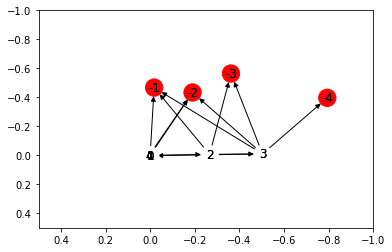

curcost 0.6643648088784049

23
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.24087516e-04 -1.76915756e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.79147608e-02 -4.69945528e-01 -9.99990003e+04 -1.14748934e+05]
 [-1.90941305e-01 -4.36086332e-01 -9.99990003e+04 -1.14748923e+05]
 [-2.65309553e-01 -6.69194883e-03  2.24972808e-01 -1.99998000e+05]
 [-3.63449305e-01 -5.66445242e-01 -9.99987750e+04 -2.19230349e+05]
 [-4.99348143e-01 -9.67194697e-03  3.24364498e-01 -2.99997000e+05]
 [-7.95178640e-01 -3.97458196e-01 -9.99986756e+04 -3.14104901e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


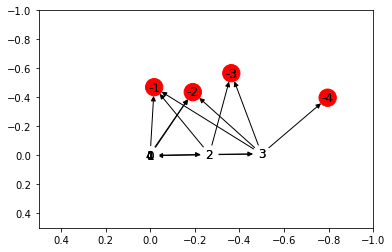

curcost 0.6573553790416482

24
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.23191166e-04 -1.76208093e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.80222494e-02 -4.72765201e-01 -9.99990003e+04 -1.15437428e+05]
 [-1.92086953e-01 -4.38702850e-01 -9.99990003e+04 -1.15437417e+05]
 [-2.64248315e-01 -6.66518104e-03  2.24972808e-01 -1.99998000e+05]
 [-3.64903102e-01 -5.68711023e-01 -9.99987750e+04 -2.20107270e+05]
 [-4.95353358e-01 -9.59457139e-03  3.24364498e-01 -2.99997000e+05]
 [-7.96768998e-01 -3.98253113e-01 -9.99986756e+04 -3.14733111e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


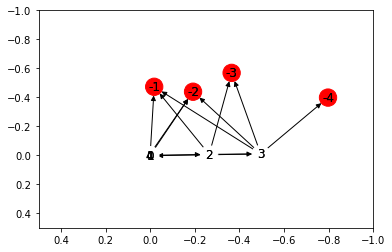

curcost 0.6507369155476784

25
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.22298401e-04 -1.75503261e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.81303829e-02 -4.75601792e-01 -9.99990003e+04 -1.16130052e+05]
 [-1.93239475e-01 -4.41335067e-01 -9.99990003e+04 -1.16130041e+05]
 [-2.63191321e-01 -6.63852031e-03  2.24972808e-01 -1.99998000e+05]
 [-3.66362715e-01 -5.70985867e-01 -9.99987750e+04 -2.20987699e+05]
 [-4.91390531e-01 -9.51781482e-03  3.24364498e-01 -2.99997000e+05]
 [-7.98362536e-01 -3.99049619e-01 -9.99986756e+04 -3.15362577e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


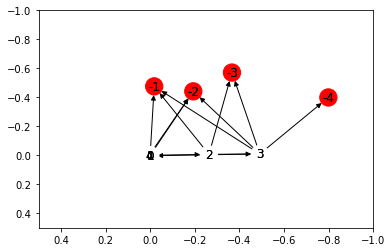

curcost 0.6445076397267029

26
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.21409208e-04 -1.74801248e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.82391652e-02 -4.78455403e-01 -9.99990003e+04 -1.16826833e+05]
 [-1.94398911e-01 -4.43983077e-01 -9.99990003e+04 -1.16826822e+05]
 [-2.62138556e-01 -6.61196623e-03  2.24972808e-01 -1.99998000e+05]
 [-3.67828166e-01 -5.73269810e-01 -9.99987750e+04 -2.21871650e+05]
 [-4.87459407e-01 -9.44167230e-03  3.24364498e-01 -2.99997000e+05]
 [-7.99959261e-01 -3.99847718e-01 -9.99986756e+04 -3.15993302e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


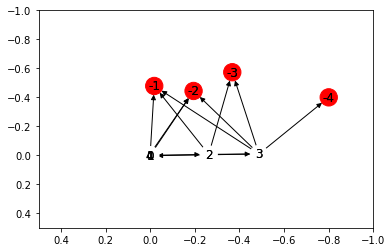

curcost 0.6386663395761889

27
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.20523571e-04 -1.74102043e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.83486002e-02 -4.81326135e-01 -9.99990003e+04 -1.17527794e+05]
 [-1.95565305e-01 -4.46646976e-01 -9.99990003e+04 -1.17527782e+05]
 [-2.61090002e-01 -6.58551837e-03  2.24972808e-01 -1.99998000e+05]
 [-3.69299478e-01 -5.75562890e-01 -9.99987750e+04 -2.22759136e+05]
 [-4.83559732e-01 -9.36613892e-03  3.24364498e-01 -2.99997000e+05]
 [-8.01559179e-01 -4.00647414e-01 -9.99986756e+04 -3.16625289e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


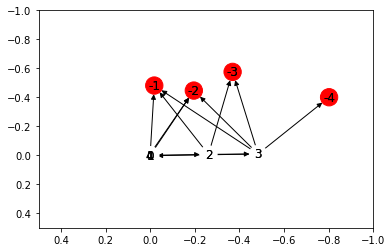

curcost 0.633212439509391

28
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.19641476e-04 -1.73405635e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.84586918e-02 -4.84214092e-01 -9.99990003e+04 -1.18232960e+05]
 [-1.96738697e-01 -4.49326857e-01 -9.99990003e+04 -1.18232949e+05]
 [-2.60045642e-01 -6.55917629e-03  2.24972808e-01 -1.99998000e+05]
 [-3.70776676e-01 -5.77865141e-01 -9.99987750e+04 -2.23650173e+05]
 [-4.79691254e-01 -9.29120981e-03  3.24364498e-01 -2.99997000e+05]
 [-8.03162298e-01 -4.01448708e-01 -9.99986756e+04 -3.17258539e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


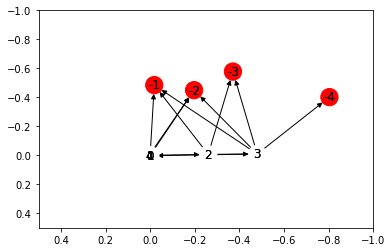

curcost 0.6281460693262557

29
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.18762911e-04 -1.72712012e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.85694439e-02 -4.87119377e-01 -9.99990003e+04 -1.18942358e+05]
 [-1.97919129e-01 -4.52022819e-01 -9.99990003e+04 -1.18942347e+05]
 [-2.59005459e-01 -6.53293959e-03  2.24972808e-01 -1.99998000e+05]
 [-3.72259783e-01 -5.80176602e-01 -9.99987750e+04 -2.24544774e+05]
 [-4.75853724e-01 -9.21688013e-03  3.24364498e-01 -2.99997000e+05]
 [-8.04768622e-01 -4.02251606e-01 -9.99986756e+04 -3.17893056e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


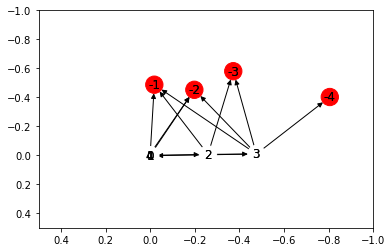

curcost 0.6234681232822352

30
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.17887859e-04 -1.72021164e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.86808606e-02 -4.90042093e-01 -9.99990003e+04 -1.19656012e+05]
 [-1.99106644e-01 -4.54734956e-01 -9.99990003e+04 -1.19656001e+05]
 [-2.57969437e-01 -6.50680783e-03  2.24972808e-01 -1.99998000e+05]
 [-3.73748822e-01 -5.82497308e-01 -9.99987750e+04 -2.25442953e+05]
 [-4.72046894e-01 -9.14314509e-03  3.24364498e-01 -2.99997000e+05]
 [-8.06378159e-01 -4.03056109e-01 -9.99986756e+04 -3.18528842e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


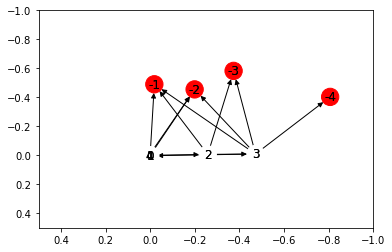

curcost 0.6191802942266613

31
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.17016307e-04 -1.71333080e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.87929457e-02 -4.92982345e-01 -9.99990003e+04 -1.20373948e+05]
 [-2.00301283e-01 -4.57463365e-01 -9.99990003e+04 -1.20373937e+05]
 [-2.56937560e-01 -6.48078060e-03  2.24972808e-01 -1.99998000e+05]
 [-3.75243817e-01 -5.84827297e-01 -9.99987750e+04 -2.26344725e+05]
 [-4.68270519e-01 -9.06999993e-03  3.24364498e-01 -2.99997000e+05]
 [-8.07990916e-01 -4.03862221e-01 -9.99986756e+04 -3.19165900e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


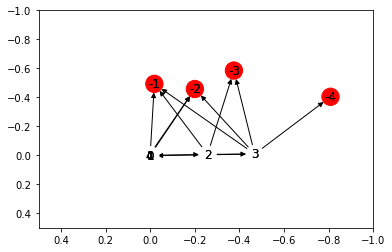

curcost 0.6152850601231912

32
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.16148242e-04 -1.70647747e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.89057034e-02 -4.95940239e-01 -9.99990003e+04 -1.21096192e+05]
 [-2.01503091e-01 -4.60208145e-01 -9.99990003e+04 -1.21096181e+05]
 [-2.55909809e-01 -6.45485748e-03  2.24972808e-01 -1.99998000e+05]
 [-3.76744793e-01 -5.87166607e-01 -9.99987750e+04 -2.27250104e+05]
 [-4.64524355e-01 -8.99743993e-03  3.24364498e-01 -2.99997000e+05]
 [-8.09606898e-01 -4.04669946e-01 -9.99986756e+04 -3.19804232e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


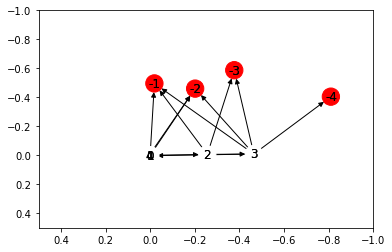

curcost 0.6117855918951784

33
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.15283649e-04 -1.69965156e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.90191376e-02 -4.98915881e-01 -9.99990003e+04 -1.21822769e+05]
 [-2.02712110e-01 -4.62969394e-01 -9.99990003e+04 -1.21822758e+05]
 [-2.54886170e-01 -6.42903805e-03  2.24972808e-01 -1.99998000e+05]
 [-3.78251772e-01 -5.89515273e-01 -9.99987750e+04 -2.28159104e+05]
 [-4.60808160e-01 -8.92546041e-03  3.24364498e-01 -2.99997000e+05]
 [-8.11226111e-01 -4.05479286e-01 -9.99986756e+04 -3.20443840e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


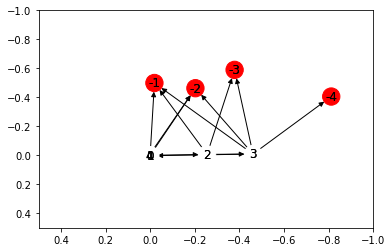

curcost 0.60868554541548

34
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.14422515e-04 -1.69285296e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.91332525e-02 -5.01909376e-01 -9.99990003e+04 -1.22553706e+05]
 [-2.03928382e-01 -4.65747211e-01 -9.99990003e+04 -1.22553694e+05]
 [-2.53866626e-01 -6.40332189e-03  2.24972808e-01 -1.99998000e+05]
 [-3.79764779e-01 -5.91873334e-01 -9.99987750e+04 -2.29071740e+05]
 [-4.57121694e-01 -8.85405673e-03  3.24364498e-01 -2.99997000e+05]
 [-8.12848564e-01 -4.06290244e-01 -9.99986756e+04 -3.21084728e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


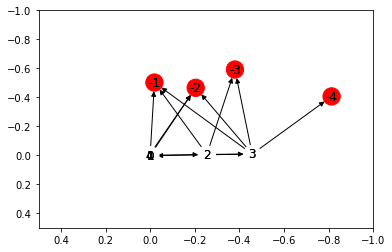

curcost 0.6059887022876226

35
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.13564825e-04 -1.68608154e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.92480520e-02 -5.04920832e-01 -9.99990003e+04 -1.23289028e+05]
 [-2.05151953e-01 -4.68541694e-01 -9.99990003e+04 -1.23289016e+05]
 [-2.52851159e-01 -6.37770861e-03  2.24972808e-01 -1.99998000e+05]
 [-3.81283838e-01 -5.94240827e-01 -9.99987750e+04 -2.29988027e+05]
 [-4.53464721e-01 -8.78322427e-03  3.24364498e-01 -2.99997000e+05]
 [-8.14474261e-01 -4.07102825e-01 -9.99986756e+04 -3.21726897e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


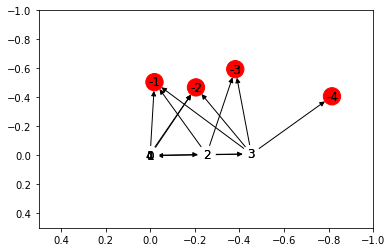

curcost 0.6036984419037149

36
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.12710565e-04 -1.67933722e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.93635403e-02 -5.07950357e-01 -9.99990003e+04 -1.24028762e+05]
 [-2.06382864e-01 -4.71352944e-01 -9.99990003e+04 -1.24028750e+05]
 [-2.51839754e-01 -6.35219777e-03  2.24972808e-01 -1.99998000e+05]
 [-3.82808973e-01 -5.96617791e-01 -9.99987750e+04 -2.30907979e+05]
 [-4.49837003e-01 -8.71295848e-03  3.24364498e-01 -2.99997000e+05]
 [-8.16103209e-01 -4.07917030e-01 -9.99986756e+04 -3.22370351e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


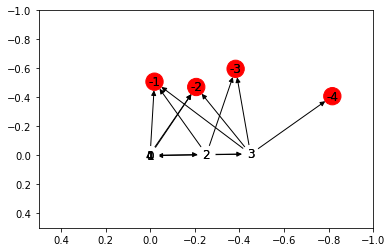

curcost 0.6018170679961169

37
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.11859723e-04 -1.67261987e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.94797215e-02 -5.10998060e-01 -9.99990003e+04 -1.24772935e+05]
 [-2.07621162e-01 -4.74181062e-01 -9.99990003e+04 -1.24772923e+05]
 [-2.50832395e-01 -6.32678898e-03  2.24972808e-01 -1.99998000e+05]
 [-3.84340209e-01 -5.99004262e-01 -9.99987750e+04 -2.31831611e+05]
 [-4.46238307e-01 -8.64325481e-03  3.24364498e-01 -2.99997000e+05]
 [-8.17735416e-01 -4.08732864e-01 -9.99986756e+04 -3.23015092e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


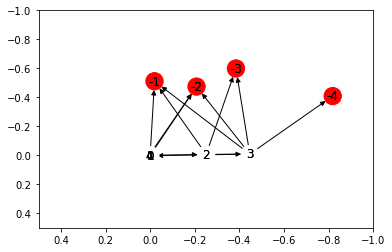

curcost 0.6003450744513237

38
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.11012284e-04 -1.66592939e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.95965999e-02 -5.14064048e-01 -9.99990003e+04 -1.25521572e+05]
 [-2.08866889e-01 -4.77026148e-01 -9.99990003e+04 -1.25521560e+05]
 [-2.49829066e-01 -6.30148182e-03  2.24972808e-01 -1.99998000e+05]
 [-3.85877570e-01 -6.01400279e-01 -9.99987750e+04 -2.32758938e+05]
 [-4.42668401e-01 -8.57410877e-03  3.24364498e-01 -2.99997000e+05]
 [-8.19370886e-01 -4.09550330e-01 -9.99986756e+04 -3.23661122e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


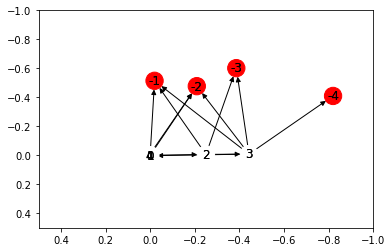

curcost 0.5992804979094841

39
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.10168235e-04 -1.65926567e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.97141795e-02 -5.17148432e-01 -9.99990003e+04 -1.26274702e+05]
 [-2.10120090e-01 -4.79888305e-01 -9.99990003e+04 -1.26274690e+05]
 [-2.48829750e-01 -6.27627590e-03  2.24972808e-01 -1.99998000e+05]
 [-3.87421080e-01 -6.03805880e-01 -9.99987750e+04 -2.33689974e+05]
 [-4.39127053e-01 -8.50551590e-03  3.24364498e-01 -2.99997000e+05]
 [-8.21009628e-01 -4.10369431e-01 -9.99986756e+04 -3.24308444e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


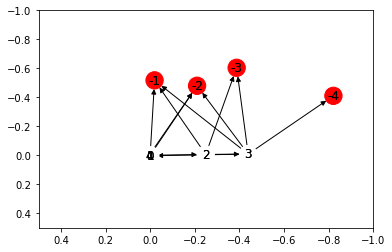

curcost 0.5986185323427841

40
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.09327562e-04 -1.65262861e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.98324645e-02 -5.20251323e-01 -9.99990003e+04 -1.27032350e+05]
 [-2.11380810e-01 -4.82767635e-01 -9.99990003e+04 -1.27032338e+05]
 [-2.47834431e-01 -6.25117079e-03  2.24972808e-01 -1.99998000e+05]
 [-3.88970765e-01 -6.06221104e-01 -9.99987750e+04 -2.34624733e+05]
 [-4.35614037e-01 -8.43747178e-03  3.24364498e-01 -2.99997000e+05]
 [-8.22651648e-01 -4.11190170e-01 -9.99986756e+04 -3.24957061e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


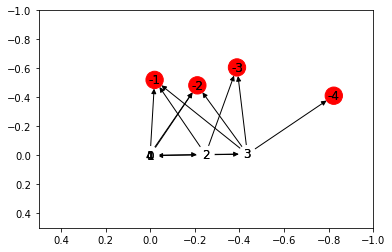

curcost 0.5983515404412333

41
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.08490252e-04 -1.64601810e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.99514593e-02 -5.23372831e-01 -9.99990003e+04 -1.27794544e+05]
 [-2.12649095e-01 -4.85664241e-01 -9.99990003e+04 -1.27794532e+05]
 [-2.46843093e-01 -6.22616611e-03  2.24972808e-01 -1.99998000e+05]
 [-3.90526648e-01 -6.08645988e-01 -9.99987750e+04 -2.35563232e+05]
 [-4.32129125e-01 -8.36997200e-03  3.24364498e-01 -2.99997000e+05]
 [-8.24296951e-01 -4.12012550e-01 -9.99986756e+04 -3.25606975e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


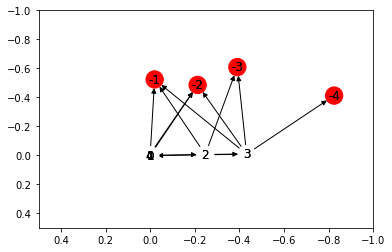

curcost 0.5984694894888766

converge
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.07656291e-04 -1.63943402e-05 -3.48399000e-04 -9.99990000e+04]
 [-2.00711681e-02 -5.26513068e-01 -9.99990003e+04 -1.28561311e+05]
 [-2.13924990e-01 -4.88578226e-01 -9.99990003e+04 -1.28561299e+05]
 [-2.45855720e-01 -6.20126145e-03  2.24972808e-01 -1.99998000e+05]
 [-3.92088754e-01 -6.11080572e-01 -9.99987750e+04 -2.36505485e+05]
 [-4.28672092e-01 -8.30301223e-03  3.24364498e-01 -2.99997000e+05]
 [-8.25945545e-01 -4.12836575e-01 -9.99986756e+04 -3.26258189e+05]
 [ 5.98949000e-03  3.08127700e-03 -1.79708490e-01 -3.99996000e+05]]


In [167]:
a.gd(iterations = 100, learning_rate = 0.001, stopping_threshold = 0.1, posegraph = True) #Remember to Change

In [168]:
from os import listdir
from os.path import isfile, join
mypath = "pose"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
print("number of jpg: "+str(len(onlyfiles)))

number of jpg: 42


In [169]:
import imageio

with imageio.get_writer('optimization.gif', mode='I') as writer:
    for filename in list(range(0,len(onlyfiles))):
        image = imageio.imread("pose/"+str(filename)+".jpg")
        writer.append_data(image)
        
print("saved")

saved


# Convergence of Gradient Descent

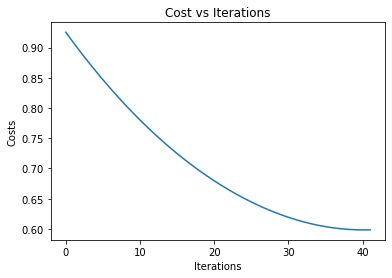

In [170]:
a.prcost()

# Comparison of Accuracy

Initial vs Ground Truth

In [171]:
initial = a.nodedata[np.where(a.node>0)] 
groundtruth = np.array([[0,0],[-0.2,0],[-0.4,0],[0,0]])
initialxy = []
initialdiff = []
initialL2 = []

for i in range(len(initial)):
    initialxy.append(initial[i][0:2].round(decimals = 3) )
    diff = initial[i][0:2]-groundtruth[i]
    initialdiff.append(diff.round(decimals = 3) )
    initialL2.append(np.linalg.norm(diff).round(decimals = 3) )

Optimized Estimate vs Ground Truth

In [172]:
optim = a.converge[np.where(a.node>0)] 
groundtruth = np.array([[0,0],[-0.2,0],[-0.4,0],[0,0]])
optimxy = []
optimdiff = []
optimL2 = []

for i in range(len(optim)):
    optimxy.append(optim[i][0:2].round(decimals = 3) )
    diff = optim[i][0:2]-groundtruth[i]
    optimdiff.append(diff.round(decimals = 3) )
    optimL2.append(np.linalg.norm(diff).round(decimals = 3) )

In [173]:
compare = pd.DataFrame(list(zip(groundtruth, initialxy, initialdiff, initialL2, optimxy, optimdiff, optimL2)), columns = ('groundtruth', 'initialxy', 'initialdiff', 'initialL2', 'optimxy', 'optimdiff', 'optimL2'))

compare

,groundtruth,initialxy,initialdiff,initialL2,optimxy,optimdiff,optimL2
0,"[0.0, 0.0]","[0.0, -0.0]","[0.0, -0.0]",0.000,"[0.0, -0.0]","[0.0, -0.0]",0.000
1,"[-0.2, 0.0]","[-0.291, -0.007]","[-0.091, -0.007]",0.091,"[-0.246, -0.006]","[-0.046, -0.006]",0.046
2,"[-0.4, 0.0]","[-0.601, -0.012]","[-0.201, -0.012]",0.201,"[-0.429, -0.008]","[-0.029, -0.008]",0.030
3,"[0.0, 0.0]","[0.006, 0.003]","[0.006, 0.003]",0.007,"[0.006, 0.003]","[0.006, 0.003]",0.007


# To Do List
1) set up controlled experiment for camera, manually extract following data (pose to pose movement, pose to frame movements, 

1) Experimental Data.
2) Offline Algorithm

*mention that initial pose tagged to global frame.
*why cost function?

In [174]:
#a.nodedata[np.where(a.node>0)]

# Comparisons

GT vs Intial vs Optimal

C:\Users\User\anaconda3\lib\site-packages\matplotlib\patches.py:2993: RuntimeWarning: invalid value encountered in double_scalars
  cos_t, sin_t = head_length / head_dist, head_width / head_dist


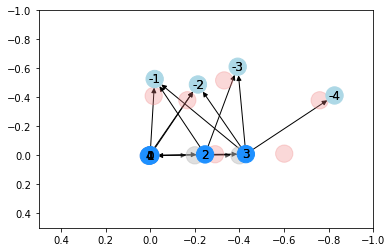

In [175]:

#Ground Truth
b = adjmatrix() 
b.posetopose(0,0,0,0) #
b.posetopose(-0.2,0,0,0) #
b.posetopose(-0.2,0,0,0) #
#b.posetopose(0,0,0,0) #
nodedata = b.nodedata

amat = b.matrix
g = nx.from_numpy_matrix(amat, create_using=nx.DiGraph)
g.remove_nodes_from(list(nx.isolates(g)))

#relabelling
mapping = dict(zip(g, b.node))
g = nx.relabel_nodes(g, mapping)

#colourmap
color_map = []
for node in g.nodes:
    if node < 0:
        color_map.append('red')
    else: 
        color_map.append('silver')      

#layout
layout = nx.spectral_layout(g)
#layout = nx.spring_layout(g)

#position
position = copy.deepcopy(nodedata)
ps = []
for pos in position:
    ps.append(pos[:2])

z = zip(b.node, ps)
dic = dict(z)

fig, ax = plt.subplots()

nx.draw_networkx(g, pos=dic, node_color = color_map, alpha = 0.5, node_size = 300,with_labels = False)
#nx.draw_networkx_labels(g, pos=dic)

#-----------------------------

#Initial
nodedata = a.nodedata

amat = a.matrix
g = nx.from_numpy_matrix(amat, create_using=nx.DiGraph)
g.remove_nodes_from(list(nx.isolates(g)))

#relabelling
mapping = dict(zip(g, a.node))
g = nx.relabel_nodes(g, mapping)

#colourmap
color_map = []
for node in g.nodes:
    if node < 0:
        color_map.append('lightcoral')
    else: 
        color_map.append('lightcoral')      

#layout
layout = nx.spectral_layout(g)
#layout = nx.spring_layout(g)

#position
position = copy.deepcopy(nodedata)
ps = []
for pos in position:
    ps.append(pos[:2])

z = zip(a.node, ps)
dic = dict(z)

#fig, ax = plt.subplots()

nx.draw_networkx(g, pos=dic, node_color = color_map, alpha = 0.3, width = 0, arrowsize = 0, with_labels = False)
#nx.draw_networkx_labels(g, pos=dic)


#-----------------------------

#Optimal
nodedata = a.converge

amat = a.matrix
g = nx.from_numpy_matrix(amat, create_using=nx.DiGraph)
g.remove_nodes_from(list(nx.isolates(g)))

#relabelling
mapping = dict(zip(g, a.node))
g = nx.relabel_nodes(g, mapping)

#colourmap
color_map = []
for node in g.nodes:
    if node < 0:
        color_map.append('lightblue')
    else: 
        color_map.append('dodgerblue')      

#layout
layout = nx.spectral_layout(g)
#layout = nx.spring_layout(g)

#position
position = copy.deepcopy(nodedata)
ps = []
for pos in position:
    ps.append(pos[:2])

z = zip(a.node, ps)
dic = dict(z)

#fig, ax = plt.subplots()

nx.draw_networkx(g, pos=dic, node_color = color_map, with_labels = True)
nx.draw_networkx_labels(g, pos=dic)

#-----------------------------


plt.axis("on")
ax.set_xlim(0.5, -1)
ax.set_ylim(0.5, -1)

ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

plt.savefig("Intial vs Optimal vs GT.jpg")

Intial vs Optimal

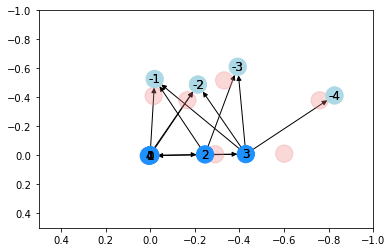

In [176]:
#-----------------------------

#Initial
nodedata = a.nodedata

amat = a.matrix
g = nx.from_numpy_matrix(amat, create_using=nx.DiGraph)
g.remove_nodes_from(list(nx.isolates(g)))

#relabelling
mapping = dict(zip(g, a.node))
g = nx.relabel_nodes(g, mapping)

#colourmap
color_map = []
for node in g.nodes:
    if node < 0:
        color_map.append('lightcoral')
    else: 
        color_map.append('lightcoral')      

#layout
layout = nx.spectral_layout(g)
#layout = nx.spring_layout(g)

#position
position = copy.deepcopy(nodedata)
ps = []
for pos in position:
    ps.append(pos[:2])

z = zip(a.node, ps)
dic = dict(z)

fig, ax = plt.subplots()

nx.draw_networkx(g, pos=dic, node_color = color_map, alpha = 0.3, width = 0, arrowsize = 0, with_labels = False)
#nx.draw_networkx_labels(g, pos=dic)


#-----------------------------

#Optimal
nodedata = a.converge

amat = a.matrix
g = nx.from_numpy_matrix(amat, create_using=nx.DiGraph)
g.remove_nodes_from(list(nx.isolates(g)))

#relabelling
mapping = dict(zip(g, a.node))
g = nx.relabel_nodes(g, mapping)

#colourmap
color_map = []
for node in g.nodes:
    if node < 0:
        color_map.append('lightblue')
    else: 
        color_map.append('dodgerblue')      

#layout
layout = nx.spectral_layout(g)
#layout = nx.spring_layout(g)

#position
position = copy.deepcopy(nodedata)
ps = []
for pos in position:
    ps.append(pos[:2])

z = zip(a.node, ps)
dic = dict(z)

#fig, ax = plt.subplots()

nx.draw_networkx(g, pos=dic, node_color = color_map, with_labels = True)
nx.draw_networkx_labels(g, pos=dic)

#-----------------------------


plt.axis("on")
ax.set_xlim(0.5, -1)
ax.set_ylim(0.5, -1)

ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

plt.savefig("Intial vs Optimal.jpg")

# Test Loop Closure

In [177]:
#df = df[0:10]
df

,Type,Match,Node,x,y,o,z
0,Pose,NaN,1,0.000246,-0.000019,-0.000348,-99999.000000
1,Feat,NaN,-1,-0.015858,-0.409518,-99999.000000,0.127412
2,Feat,NaN,-2,-0.166643,-0.380012,-99999.000000,0.136918
3,Pose,NaN,2,-0.291175,-0.007319,0.225321,-99999.000000
4,Feat,-1.0,-1,-0.039523,-0.507076,-99999.000000,0.169411
5,Feat,NaN,-3,-0.040635,-0.509414,-99999.000000,0.171712
6,Pose,NaN,3,-0.309739,-0.004296,0.099392,-99999.000000
7,Feat,-2.0,-2,-0.159924,-0.368080,-99999.000000,-0.143533
8,Feat,NaN,-4,-0.158795,-0.367972,-99999.000000,-0.142006
9,Feat,-1.0,-1,-0.039531,-0.495899,-99999.000000,0.174748


In [178]:
loop = adjmatrix() 
for i in range(11):
    e  = df.iloc[i]
    if e.Type == 'Pose':
        loop.posetopose(e.x,e.y,e.o,e.z) #new pose x,y,o,{z}
    else:
        if pd.isna(e.Match):
            #add new feat
            loop.posetonewfeat(e.x,e.y,e.o,e.z)
        else:
            #old feat, link
            loop.posetooldfeat(e.x,e.y,e.o,e.z,e.Match)
            
e = df.iloc[11]
loop.poseloopclosure(e.x,e.y,e.o,e.z, 1)
e = df.iloc[12]
loop.posetooldfeat(e.x,e.y,e.o,e.z,-2)

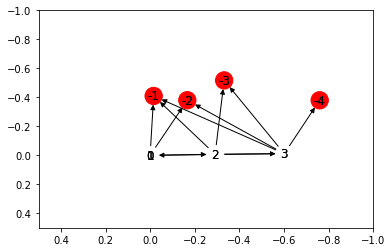

In [179]:
loop.graph_posegraph([],0)

In [180]:
loop.gd(iterations = 1000, learning_rate = 0.001, stopping_threshold = 0.1, posegraph = False) #Remember to Change

original
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.45727000e-04 -1.94000000e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.56119610e-02 -4.09537773e-01 -9.99990003e+04 -9.99988726e+04]
 [-1.66397321e-01 -3.80030907e-01 -9.99990003e+04 -9.99988631e+04]
 [-2.90929730e-01 -7.33817100e-03  2.24972808e-01 -1.99998000e+05]
 [-3.31564823e-01 -5.16752443e-01 -9.99987750e+04 -1.99997828e+05]
 [-6.00668669e-01 -1.16344390e-02  3.24364498e-01 -2.99997000e+05]
 [-7.59463857e-01 -3.79606694e-01 -9.99986756e+04 -2.99997142e+05]]
in [0, 2, 3, 2, 1, 2, 1, 1]
out [1, 3, 0, 0, 3, 0, 5, 0]
factor [-2, -2, 6, 4, -4, 4, -8, 2]


0
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.45727000e-04 -1.94000000e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.56119610e-02 -4.09537773e-01 -9.99990003e+04 -9.99988726e+04]
 [-1.66397321e-01 -3.80030907e-01 -9.99990003e+04 -9.99988631e+04]
 [-2.90929730e-01 -7.33817100e-03  2.24972808e-01 -1.99998000e+05]
 [-3.31564823e-01 -5.1

In [181]:
initial = loop.nodedata[np.where(loop.node>0)] 
groundtruth = np.array([[0,0],[-0.2,0],[-0.4,0],[0,0]])
initialxy = []
initialdiff = []
initialL2 = []

for i in range(len(initial)):
    initialxy.append(initial[i][0:2].round(decimals = 3) )
    diff = initial[i][0:2]-groundtruth[i]
    initialdiff.append(diff.round(decimals = 3) )
    initialL2.append(np.linalg.norm(diff).round(decimals = 3) )

In [182]:
optim = loop.converge[np.where(loop.node>0)] 
groundtruth = np.array([[0,0],[-0.2,0],[-0.4,0],[0,0]])
optimxy = []
optimdiff = []
optimL2 = []

for i in range(len(optim)):
    optimxy.append(optim[i][0:2].round(decimals = 3) )
    diff = optim[i][0:2]-groundtruth[i]
    optimdiff.append(diff.round(decimals = 3) )
    optimL2.append(np.linalg.norm(diff).round(decimals = 3) )

With Loop Closure

In [183]:
compare_lc = pd.DataFrame(list(zip(groundtruth, initialxy, initialdiff, initialL2, optimxy, optimdiff, optimL2)), columns = ('groundtruth', 'initialxy', 'initialdiff', 'initialL2', 'optimxy', 'optimdiff', 'optimL2'))
compare_lc

,groundtruth,initialxy,initialdiff,initialL2,optimxy,optimdiff,optimL2
0,"[0.0, 0.0]","[0.0, -0.0]","[0.0, -0.0]",0.000,"[0.0, -0.0]","[0.0, -0.0]",0.000
1,"[-0.2, 0.0]","[-0.291, -0.007]","[-0.091, -0.007]",0.091,"[-0.243, -0.006]","[-0.043, -0.006]",0.043
2,"[-0.4, 0.0]","[-0.601, -0.012]","[-0.201, -0.012]",0.201,"[-0.418, -0.008]","[-0.018, -0.008]",0.020


Without Loop Closure

In [184]:
compare

,groundtruth,initialxy,initialdiff,initialL2,optimxy,optimdiff,optimL2
0,"[0.0, 0.0]","[0.0, -0.0]","[0.0, -0.0]",0.000,"[0.0, -0.0]","[0.0, -0.0]",0.000
1,"[-0.2, 0.0]","[-0.291, -0.007]","[-0.091, -0.007]",0.091,"[-0.246, -0.006]","[-0.046, -0.006]",0.046
2,"[-0.4, 0.0]","[-0.601, -0.012]","[-0.201, -0.012]",0.201,"[-0.429, -0.008]","[-0.029, -0.008]",0.030
3,"[0.0, 0.0]","[0.006, 0.003]","[0.006, 0.003]",0.007,"[0.006, 0.003]","[0.006, 0.003]",0.007


C:\Users\User\anaconda3\lib\site-packages\matplotlib\patches.py:2993: RuntimeWarning: invalid value encountered in double_scalars
  cos_t, sin_t = head_length / head_dist, head_width / head_dist


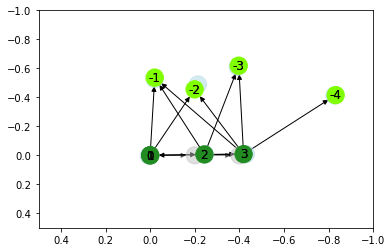

In [185]:
#Ground Truth
b = adjmatrix() 
b.posetopose(0,0,0,0) #
b.posetopose(-0.2,0,0,0) #
b.posetopose(-0.2,0,0,0) #
#b.posetopose(0,0,0,0) #
nodedata = b.nodedata

amat = b.matrix
g = nx.from_numpy_matrix(amat, create_using=nx.DiGraph)
g.remove_nodes_from(list(nx.isolates(g)))

#relabelling
mapping = dict(zip(g, b.node))
g = nx.relabel_nodes(g, mapping)

#colourmap
color_map = []
for node in g.nodes:
    if node < 0:
        color_map.append('red')
    else: 
        color_map.append('silver')      

#layout
layout = nx.spectral_layout(g)
#layout = nx.spring_layout(g)

#position
position = copy.deepcopy(nodedata)
ps = []
for pos in position:
    ps.append(pos[:2])

z = zip(b.node, ps)
dic = dict(z)

fig, ax = plt.subplots()

nx.draw_networkx(g, pos=dic, node_color = color_map, alpha = 0.5, node_size = 300,with_labels = False)
#nx.draw_networkx_labels(g, pos=dic)


#-----------------------------

#Optimal without Loop Closure
nodedata = a.converge

amat = a.matrix
g = nx.from_numpy_matrix(amat, create_using=nx.DiGraph)
g.remove_nodes_from(list(nx.isolates(g)))

#relabelling
mapping = dict(zip(g, a.node))
g = nx.relabel_nodes(g, mapping)

#colourmap
color_map = []
for node in g.nodes:
    if node < 0:
        color_map.append('lightblue')
    else: 
        color_map.append('lightblue')      

#layout
layout = nx.spectral_layout(g)
#layout = nx.spring_layout(g)

#position
position = copy.deepcopy(nodedata)
ps = []
for pos in position:
    ps.append(pos[:2])

z = zip(a.node, ps)
dic = dict(z)

#fig, ax = plt.subplots()

nx.draw_networkx(g, pos=dic, node_color = color_map, alpha = 0.5, width = 0, arrowsize = 0, with_labels = False)
#nx.draw_networkx_labels(g, pos=dic)

#-----------------------------

#Optimal with Loop Closure
nodedata = loop.converge

amat = loop.matrix
g = nx.from_numpy_matrix(amat, create_using=nx.DiGraph)
g.remove_nodes_from(list(nx.isolates(g)))

#relabelling
mapping = dict(zip(g, loop.node))
g = nx.relabel_nodes(g, mapping)

#colourmap
color_map = []
for node in g.nodes:
    if node < 0:
        color_map.append('chartreuse')
    else: 
        color_map.append('forestgreen')      

#layout
layout = nx.spectral_layout(g)
#layout = nx.spring_layout(g)

#position
position = copy.deepcopy(nodedata)
ps = []
for pos in position:
    ps.append(pos[:2])

z = zip(loop.node, ps)
dic = dict(z)

#fig, ax = plt.subplots()

nx.draw_networkx(g, pos=dic, node_color = color_map, with_labels = True)
nx.draw_networkx_labels(g, pos=dic)

#-----------------------------


plt.axis("on")
ax.set_xlim(0.5, -1)
ax.set_ylim(0.5, -1)

ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

plt.savefig("LoopClosure vs NonLoopClosure.jpg")